# Przykładowy kod rozwiązania zadania konkursowego

## Pobranie i rozpakowanie danych

In [ ]:
! conda install tensorflow

lub pobierz dane samodzielnie/wykorzystując odpowiednie zależności z google drive

### Rozpakowanie danych

In [3]:
!unzip -q train.zip

## Zaimportowanie zależności

In [1]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from sklearn.utils import class_weight
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Conv2D
from PIL import Image
import scipy.misc
random.seed()

C:\Users\Szymon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Przykładowe wykorzystanie

In [2]:
target_size = (160,160)

In [3]:
! ls train | grep csv

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
data_df = pd.read_csv('extended_data.csv',header = None, names = ['filename','class'])

In [5]:
data_df.head()

,filename,class
0,00001.jpg,0
1,00002.jpg,0
2,00003.jpg,0
3,00004.jpg,1
4,00005.jpg,0


In [6]:
data_df.tail()

,filename,class
104939,extended74943.jpg,1
104940,extended74959.jpg,1
104941,extended74959.jpg,1
104942,extended74959.jpg,1
104943,extended74959.jpg,1


In [7]:
def rotateImage(image):
    angle = random.randint(1,101)
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR, borderValue=(255,255,255))
    return result
aaa dont run this anymore
num = 4
df = pd.DataFrame()
for filename in data_df.loc[data_df['class'] == 1 ,'filename']:
    for i in range(num):
        path = 'train/' + filename
        im = Image.open(path)
        np_im = np.array(im)
        new_image = rotateImage(np_im)
        scipy.misc.toimage(new_image, cmin=0.0, cmax=...).save('train/extended{}_{}'.format(i,filename))
        df = df.append(pd.DataFrame({"filename":['extended{}'.format(filename)], "class": [1]}))
data_df = data_df.append(df, ignore_index=True)
print(data_df.tail())

SyntaxError: invalid syntax (<ipython-input-7-cf6836feb036>, line 7)

In [8]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = lambda x: x/255,
    rotation_range=5, 
    width_shift_range=0.05, 
    height_shift_range=0.05, 
    shear_range=0.05, 
    zoom_range=0.1, 
    horizontal_flip=True, 
    vertical_flip=True)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = lambda x: x/255)

In [9]:
mask = np.random.rand(len(data_df)) < 0.8
train_df = data_df[mask]
val_df = data_df[~mask]

In [10]:
print('% of positive in training DS = {}'.format(np.sum(train_df['class'].values==1)/len(train_df)))
print('% of positive in validation DS = {}'.format(np.sum(val_df['class'].values==1)/len(val_df)))

% of positive in training DS = 0.3567254251842664
% of positive in validation DS = 0.3588017821594464


In [11]:
train_gen = train_gen.flow_from_dataframe(train_df, directory = 'train', class_mode = 'other', target_size=target_size, batch_size = 128, shuffle=False)
val_gen = val_gen.flow_from_dataframe(val_df, directory = 'train', class_mode = 'other', target_size=target_size, batch_size = 128,shuffle=False)

Found 59918 images.
Found 15042 images.


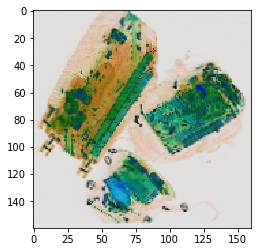

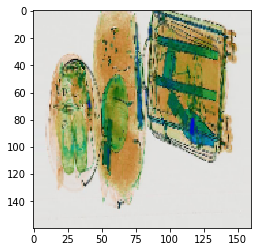

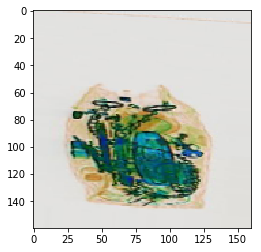

In [12]:
for i in train_gen[0][0][:3]:
    plt.imshow(np.squeeze(i))
    plt.show()

In [13]:
def CNNbuild(height, width, classes, channels):
    model = Sequential()
    
    inputShape = (height, width, channels)
    chanDim = -1
    
    model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = inputShape))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(324, activation = 'relu'))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation = 'softmax'))
    model.add(Dense(512, activation = 'relu'))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation = 'softmax'))
    
    model.add(Dense(164, activation = 'relu'))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation = 'relu'))
    
    return model

model = CNNbuild(160,160,2,3)
model.compile('adam', 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
checkpt = tf.keras.callbacks.ModelCheckpoint('model1.h5', save_best_only=True)
model.fit_generator(train_gen, validation_data = val_gen, callbacks = [checkpt],
                    steps_per_epoch = 1, epochs = 3, verbose = 1, workers=7)

Epoch 1/3
 42/469 [=>............................] - ETA: 14:47 - loss: 0.7052 - acc: 0.8406

In [15]:
model.load_weights('model1.h5')


In [16]:
y_pred = model.predict_generator(val_gen)
print(y_pred)

[[1.4086771  0.        ]
 [0.         0.        ]
 [1.9918969  0.70254487]
 ...
 [0.         0.        ]
 [1.9795496  0.68174267]
 [0.         0.        ]]


In [17]:
print('acc = {}'.format(100*(np.sum(np.argmax(y_pred,axis=1)==val_df['class'].values)/len(val_df))))


acc = 0.0


C:\Users\Szymon\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [18]:
metrics.confusion_matrix(val_df['class'].values, np.argmax(y_pred, axis=1))


ValueError: Found input variables with inconsistent numbers of samples: [21098, 15042]

In [ ]:
print(metrics.classification_report(val_df['class'].values, np.argmax(y_pred, axis=1)))


In [ ]:
metrics.roc_auc_score(val_df['class'].values, y_pred[:,1])


In [16]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory='test/',
    target_size=(160, 160),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False
)


Found 13412 images belonging to 1 classes.


In [17]:
test_generator.reset()


pred=model.predict_generator(test_generator,steps=13412)

In [18]:
print(pred)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [19]:
import csv
counter = 1
f =  open('predictions6.csv', 'w')
for out in pred:
    line = str(format(counter, "05")) +'.jpg,' + str(out[0]) + '\n'
    f.write(line)
    counter+=1
f.close()


In [25]:
aaaaaaaaaa
data_df.to_csv(r'extended_data.csv')